<a href="https://colab.research.google.com/github/Tusharsd123/Algorithms/blob/master/COVID_19_analysis_Tushar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COVID 19 Predictions and Analysis

* 

# Library

In [0]:
# utility libraries
from datetime import timedelta

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import folium

# color pallette
cnf = '#393e46' # confirmed - grey
dth = '#ff2e63' # death - red
rec = '#21bf73' # recovered - cyan
act = '#fe9801' # active case - yellow

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Dataset

In [2]:
! ls ../input/covid19-corona-virus-india-dataset

ls: cannot access '../input/covid19-corona-virus-india-dataset': No such file or directory


In [3]:
# importing datasets
df = pd.read_csv('complete.csv', parse_dates=['Date'])
df['Name of State / UT'] = df['Name of State / UT'].str.replace('Union Territory of ', '')
df.head()

Date Name of State / UT  ...  Death  Total Confirmed cases *
0 2020-01-30             Kerala  ...      0                        1
1 2020-01-31             Kerala  ...      0                        1
2 2020-02-01             Kerala  ...      0                        2
3 2020-02-02             Kerala  ...      0                        3
4 2020-02-03             Kerala  ...      0                        3

[5 rows x 9 columns]

In [4]:
df.columns

Index(['Date', 'Name of State / UT', 'Total Confirmed cases (Indian National)',
       'Total Confirmed cases ( Foreign National )',
       'Cured/Discharged/Migrated', 'Latitude', 'Longitude', 'Death',
       'Total Confirmed cases *'],
      dtype='object')

# Preprocessing

### Cleaning

In [5]:
for i in ['Total Confirmed cases (Indian National)', 'Total Confirmed cases ( Foreign National )', 'Cured/Discharged/Migrated', 'Death']:
    df[i] = df[i].astype('int')
    
df['Total cases'] = df['Total Confirmed cases (Indian National)'] + df['Total Confirmed cases ( Foreign National )']
df['Moratlity rate'] = df['Death']/df['Total cases']
df['Recovery rate'] = df['Cured/Discharged/Migrated']/df['Total cases']
df['Active'] = df['Total cases'] - df['Death'] - df['Cured/Discharged/Migrated']

df.columns = ['Date', 'State/UT','Total Confirmed cases (Indian National)', 'Total Confirmed cases ( Foreign National )', 'Cured/Discharged/Migrated', 'Latitude', 'Longitude', 'Death', 'Total cases', 'Mortality rate', 'Recovery rate', 'Active','Total Confirmed cases *']
df = df[['Date', 'State/UT','Total Confirmed cases (Indian National)', 'Total Confirmed cases ( Foreign National )' , 'Cured/Discharged/Migrated', 'Latitude', 'Longitude', 'Death', 'Total cases', 'Mortality rate', 'Recovery rate', 'Active','Total Confirmed cases *']]

df.head()

Date State/UT  ...  Active  Total Confirmed cases *
0 2020-01-30   Kerala  ...     0.0                        1
1 2020-01-31   Kerala  ...     0.0                        1
2 2020-02-01   Kerala  ...     0.0                        2
3 2020-02-02   Kerala  ...     0.0                        3
4 2020-02-03   Kerala  ...     0.0                        3

[5 rows x 13 columns]

### Derived Tables

In [0]:
latest = df[df['Date']==max(df['Date'])]

# days
latest_day = max(df['Date'])
day_before = latest_day - timedelta(days = 1)

# state and total cases 
latest_day_df = df[df['Date']==latest_day].set_index('State/UT')
day_before_df = df[df['Date']==day_before].set_index('State/UT')

# latest_cases.columns = ['lat_cases']
# db_cases.columns = ['db_cases']

# temp = pd.concat([latest_cases, db_cases], axis=1, sort=True).reset_index()
# temp['New cases'] = temp['lat_cases']-temp['db_cases']

temp = pd.merge(left = latest_day_df, right = day_before_df, on='State/UT', suffixes=('_lat', '_bfr'), how='outer')
latest_day_df['New cases'] = temp['Total cases_lat'] - temp['Total cases_bfr']
latest = latest_day_df.reset_index()
latest.fillna(1, inplace=True)

In [7]:
print(latest_day, day_before)

2020-03-30 00:00:00 2020-03-29 00:00:00


# Table

In [8]:
temp = latest[['State/UT','Total Confirmed cases (Indian National)', 'Total Confirmed cases ( Foreign National )', 'Total cases', 'Active', 'New cases',
               'Death', 'Mortality rate', 'Cured/Discharged/Migrated', 'Recovery rate']]
temp = temp.sort_values('Total Confirmed cases (Indian National)', ascending=False).reset_index(drop=True)

temp.style\
    .background_gradient(cmap="Blues", subset=['Total Confirmed cases (Indian National)', 'Total Confirmed cases ( Foreign National )', 'Total cases', 'Active', 'New cases'])\
    .background_gradient(cmap="Greens", subset=['Cured/Discharged/Migrated', 'Recovery rate'])\
    .background_gradient(cmap="Reds", subset=['Death', 'Mortality rate'])

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1031: RuntimeWarning:

invalid value encountered in double_scalars



In [9]:
temp = pd.DataFrame(temp.loc[:, ['Total Confirmed cases (Indian National)', 'Total Confirmed cases ( Foreign National )', 'Total cases', 'Active', 'New cases', 'Death', 'Cured/Discharged/Migrated']].sum()).T
temp.index = ['Total']
temp.style\
    .background_gradient(cmap="Blues", subset=['Total Confirmed cases (Indian National)', 'Total Confirmed cases ( Foreign National )', 'Total cases', 'Active', 'New cases'])\
    .background_gradient(cmap="Greens", subset=['Cured/Discharged/Migrated', 'Recovery rate'])\
    .background_gradient(cmap="Reds", subset=['Death', 'Mortality rate'])

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1029: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



In [10]:
tm = temp.melt(id_vars="Date", value_vars=['Active', 'Death', 'Cured/Discharged/Migrated'])
fig = px.treemap(tm, path=["variable"], values="value", height=400, width=600,
                 color_discrete_sequence=[rec, act, dth])
fig.data[0].textinfo = 'label+text+value'
fig.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



# Map

* Blue circle - Latest number of Confirmed Indian Nationals  
* Red Circle - Latest number of Confirmed Foreign Nationals

In [11]:
m = folium.Map(location=[20.5937, 78.9629], tiles='cartodbpositron',
               min_zoom=4, max_zoom=6, zoom_start=4)

for i in range(0, len(latest)):
    if latest.iloc[i]['Total Confirmed cases (Indian National)']>0:
        folium.Circle(
            location=[latest.iloc[i]['Latitude'], latest.iloc[i]['Longitude']],
            color='#3f72af', 
            fill='#3f72af',
            tooltip =   '<li><bold>Name of State / UT : '+str(latest.iloc[i]['State/UT'])+
                        '<li><bold>Total Confirmed cases (Indian National) : '+str(latest.iloc[i]['Total Confirmed cases (Indian National)'])+
                        '<li><bold>Total Confirmed cases ( Foreign National ) : '+str(latest.iloc[i]['Total Confirmed cases ( Foreign National )']),
            radius=int(latest.iloc[i]['Total Confirmed cases (Indian National)'])*2000).add_to(m)

for i in range(0, len(latest)):
    if latest.iloc[i]['Total Confirmed cases ( Foreign National )']>0:
        folium.Circle(
            location=[latest.iloc[i]['Latitude'], latest.iloc[i]['Longitude']],
            color='#e84545', 
            fill='#e84545',
            tooltip =   '<li><bold>Name of State / UT : '+str(latest.iloc[i]['State/UT'])+
                        '<li><bold>Total Confirmed cases (Indian National) : '+str(latest.iloc[i]['Total Confirmed cases (Indian National)'])+
                        '<li><bold>Total Confirmed cases ( Foreign National ) : '+str(latest.iloc[i]['Total Confirmed cases ( Foreign National )']),
            radius=int(latest.iloc[i]['Total Confirmed cases ( Foreign National )'])*2000).add_to(m)
m

# OVER-TIME TRANSMISSION OF CORONA VIRUS IN INDIA

In [15]:
configure_plotly_browser_state()
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

temp = df.copy()
temp['Date'] = temp['Date'].dt.strftime('%Y/%m/%d')

fig = px.scatter_geo(temp, lat="Latitude", lon="Longitude", color='Total cases', size='Total cases', projection="natural earth",
                     hover_name="State/UT", scope='asia', animation_frame="Date", center={'lat':20, 'lon':78}, 
                     range_color=[0, max(temp['Total cases'])])
fig.show()

In [50]:
configure_plotly_browser_state()
temp = latest.sort_values('Total cases', ascending=False)
state_order = temp['State/UT']

fig = px.bar(temp, 
             x="Total cases", y="State/UT", color='State/UT', title='Total cases',
             orientation='h', text='Total cases', height=900,
             color_discrete_sequence = px.colors.qualitative.Vivid)
fig.show()

In [51]:
configure_plotly_browser_state()
px.bar(latest[latest['Death']>0].sort_values('Death'), y="State/UT", x="Death", orientation='h', 
       title='Death', color_discrete_sequence = ['#ff2e63'], text='Death')

In [52]:
configure_plotly_browser_state()
px.bar(latest[latest['Cured/Discharged/Migrated']>0].sort_values('Cured/Discharged/Migrated'), y="State/UT", x="Cured/Discharged/Migrated", orientation='h', 
       title='Cured/Discharged/Migrated', color_discrete_sequence = ['#2c786c'], text='Cured/Discharged/Migrated')

In [16]:
configure_plotly_browser_state()
temp = df.melt(id_vars="Date", value_vars=['Total Confirmed cases (Indian National)', 'Total Confirmed cases ( Foreign National )'], var_name='Case', value_name='Count')
temp = temp.groupby(['Date', 'Case'])['Count'].sum().reset_index()
temp.head()

fig = px.bar(temp, x="Date", y="Count", color='Case', text='Count', title='Cases over time',color_discrete_sequence = ['#0f4c75', '#3282b8'])
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [17]:
configure_plotly_browser_state()
fig = px.bar(df.sort_values('Total cases', ascending=False), x="Date", y="Total cases", color='State/UT', title='Cases over time',
             color_discrete_sequence = px.colors.qualitative.Vivid)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [19]:
configure_plotly_browser_state()
temp = latest.sort_values('Total cases', ascending=True)

fig = go.Figure(data=[
    go.Bar(name='Active', y=temp['State/UT'], x=temp['Active'], orientation='h'),
    go.Bar(name='Death', y=temp['State/UT'], x=temp['Death'], orientation='h'),
    go.Bar(name='Cured/Discharged/Migrated', y=temp['State/UT'], x=temp['Cured/Discharged/Migrated'], orientation='h')
])
# Change the bar mode
fig.update_layout(barmode='stack', height=900)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [20]:
configure_plotly_browser_state()
fig = px.treemap(latest, path=["State/UT"], values="Total cases", height=700,
                 title='Number of Confirmed Cases', color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

In [21]:
configure_plotly_browser_state()
no_of_states = df.groupby('Date')['State/UT'].unique().apply(len).values
dates = df.groupby('Date')['State/UT'].unique().apply(len).index

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates, y=[36 for i in range(len(no_of_states))], 
                         mode='lines', name='Total no. of States+UT', 
                         line = dict(color='#393e46', dash='dash')))

fig.add_trace(go.Scatter(x=dates, y=no_of_states, hoverinfo='x+y',
                         mode='lines', name='No. of affected States+UT', 
                         line = dict(color='#ff2e63')))

fig.update_layout(title='No. of affected States / Union Territory', 
                  xaxis_title='Date', yaxis_title='No. of affected States / Union Territory')
fig.update_traces(textposition='top center')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [23]:
configure_plotly_browser_state()
px.scatter(latest[latest['Total cases']>10], x='Total cases', y='Death', color='State/UT', size='Total cases', text='State/UT', log_x =True, title='Confirmed vs Death')

In [24]:
configure_plotly_browser_state()
px.scatter(latest[latest['Total cases']>10], x='Total cases', y='Cured/Discharged/Migrated', color='State/UT', size='Total cases', text='State/UT', log_x =True, title='Confirmed vs Cured')

In [25]:
configure_plotly_browser_state()
px.scatter_3d(latest[latest['Total cases']>10], x='Total cases', y='Death', z='Cured/Discharged/Migrated', size='Total cases', color='State/UT', text='State/UT', title='Confirmed vs Deaths vs Cured')

In [27]:
configure_plotly_browser_state()
temp = df.copy(deep=True)
temp['Date'] = temp['Date'].dt.strftime('%Y-%m-%d')
temp = temp.pivot(index='Date', columns='State/UT', values='Total cases').fillna(0).astype('int').reset_index()
temp = temp.melt(id_vars='Date', value_name='Total cases')
temp['Total cases'] = temp['Total cases'].astype('int')
# temp = temp.sort_values('Total cases', ascending=False)
temp.head()

fig = px.bar(temp, y='State/UT', x='Total cases', color='State/UT', orientation='h', 
             text='Total cases', title='Over the time', animation_frame='Date', range_x=[0, 200], height=1000)
fig.update_layout(yaxis={'categoryorder':'array'})
fig.show()

#ALL STATES TOTAL-CASES CURVES


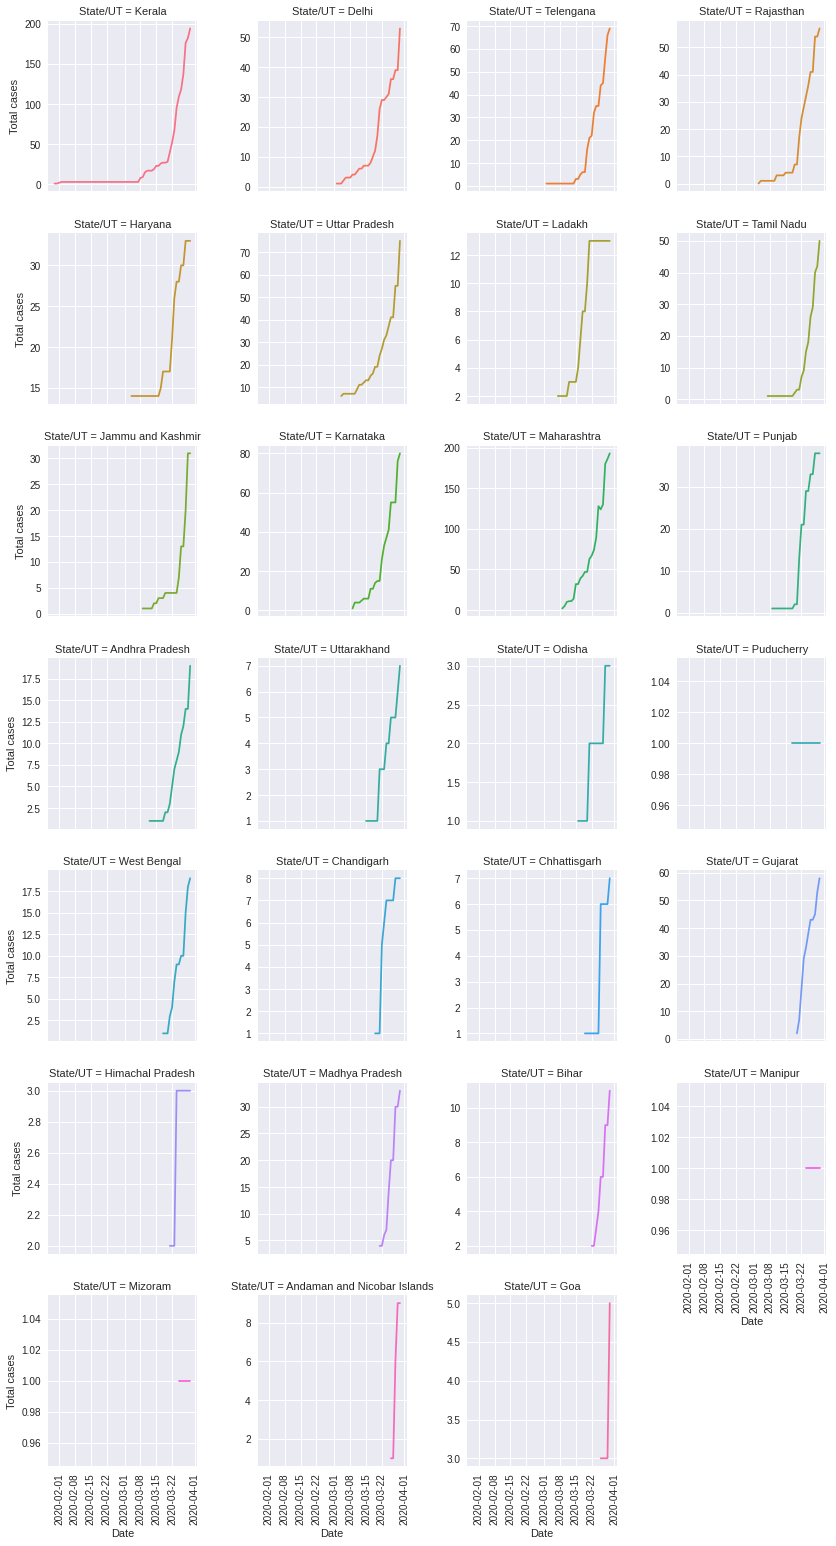

In [28]:
configure_plotly_browser_state()
temp = df.groupby(['Date', 'State/UT'])['Total cases'].sum()
temp = temp.reset_index().sort_values(by=['Date', 'State/UT'])

plt.style.use('seaborn')
g = sns.FacetGrid(temp, col="State/UT", hue="State/UT", sharey=False, col_wrap=4)
g = g.map(plt.plot, "Date", "Total cases")
g.set_xticklabels(rotation=90)
plt.show()

In [29]:

confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = death_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

full_table = confirmed_table.merge(death_table).merge(recovered_table)

full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table

Province/State  Country/Region  ... Deaths  Recovered
0                                   Afghanistan  ...      0          0
1                                       Albania  ...      0          0
2                                       Algeria  ...      0          0
3                                       Andorra  ...      0          0
4                                        Angola  ...      0          0
...                         ...             ...  ...    ...        ...
16179                                     Burma  ...      0          0
16180                  Anguilla  United Kingdom  ...      0          0
16181    British Virgin Islands  United Kingdom  ...      0          0
16182  Turks and Caicos Islands  United Kingdom  ...      0          0
16183                                MS Zaandam  ...      0          0

[16184 rows x 6 columns]

In [30]:
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China') 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table

Province/State  Country/Region  ... Recovered  Active
0                                   Afghanistan  ...         0       0
1                                       Albania  ...         0       0
2                                       Algeria  ...         0       0
3                                       Andorra  ...         0       0
4                                        Angola  ...         0       0
...                         ...             ...  ...       ...     ...
16179                                     Burma  ...         0      10
16180                  Anguilla  United Kingdom  ...         0       2
16181    British Virgin Islands  United Kingdom  ...         0       2
16182  Turks and Caicos Islands  United Kingdom  ...         0       4
16183                                MS Zaandam  ...         0       2

[16184 rows x 7 columns]

In [0]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed', 'Deaths', 'Recovered', 'Active'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]


def get_time_series_province(province):
    # for some countries, data is spread over several Provinces
    df = full_table[(full_table['Province/State'] == province)]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]

In [32]:
country = 'India'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail(10)

Confirmed  Deaths  Recovered  Active
Date                                            
2020-03-20        244       5         20     219
2020-03-21        330       4         23     303
2020-03-22        396       7         27     362
2020-03-23        499      10         27     462
2020-03-24        536      10         40     486
2020-03-25        657      12         43     602
2020-03-26        727      20         45     662
2020-03-27        887      20         73     794
2020-03-28        987      24         84     879
2020-03-29       1024      27         95     902

# ALGORITHM TO PREDICT FUTURE OUTCOME OF CORONA IN THE COUNTRY

In [0]:
import math
def model_with_lag(N, a, alpha, lag, t):
    lag = min(max(lag, -100), 100)  
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [0]:
model_index = 0

def model_loss(params):
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
#         r += (math.log(1 + model(N, a, alpha, t)) - math.log(1 + df.iloc[t, 0])) ** 2 
#         r += (model_with_lag(N, a, alpha, lag, t) - df.iloc[t, 0]) ** 2
#         print(model(N, a, alpha, t), df.iloc[t, 0])
    return math.sqrt(r)

In [35]:
import numpy as np
from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
opt_deaths

array([1.35398040e+05, 1.64715011e-02, 2.10434407e+01])

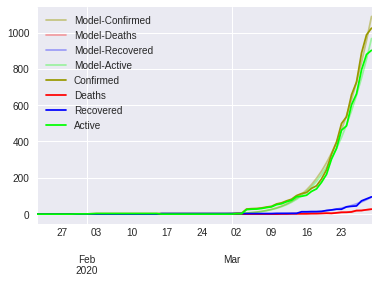

In [36]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

model_sim['Model-Active'] = model_sim['Model-Confirmed'] - model_sim['Model-Deaths'] - model_sim['Model-Recovered']
model_sim.loc[model_sim['Model-Active']<0,'Model-Active'] = 0
plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([model_sim, df], axis=1).plot(color = plot_color)
plt.show()

# PREDICTIONS

India COVID-19 Prediction


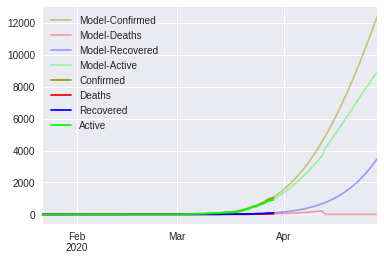

In [37]:
import datetime
start_date = df.index[0]
n_days = len(df) + 30
extended_model_x = []
last_row = []

isValid = True
last_death_rate = 0

for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
    
    #if deaths + recovered > confirmed or deaths rate > 12%, maybe not valid
    if (t > len(df)):
        last_row = extended_model_x[-1]
        if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.12):
            if (isValid):
                last_row2 = extended_model_x[-2]
                last_death_rate = last_row2[2]/last_row2[1] 
                isValid = False

        if (last_row[2] > last_row[1]*0.05):
            last_row[2] = last_row[1]*last_death_rate
            
        if (last_row[2] + last_row[3] > last_row[1]):
            last_row[2] = last_row[1]*last_death_rate
            last_row[3] = last_row[1]*(1-last_death_rate)

extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)

extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']
extended_model_sim['Model-Active'] = extended_model_sim['Model-Confirmed'] - extended_model_sim['Model-Deaths'] - extended_model_sim['Model-Recovered']
extended_model_sim.loc[extended_model_sim['Model-Active']<0,'Model-Active'] = 0
plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([extended_model_sim, df], axis=1).plot(color = plot_color)
print('India COVID-19 Prediction')
plt.show()

In [38]:
df.tail()

Confirmed  Deaths  Recovered  Active
Date                                            
2020-03-25        657      12         43     602
2020-03-26        727      20         45     662
2020-03-27        887      20         73     794
2020-03-28        987      24         84     879
2020-03-29       1024      27         95     902

In [39]:
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 3 == 0]

Confirmed  ...         Model-Active
2020-01-24                    0  ...                    0
2020-01-27                    0  ...                    0
2020-01-30                    1  ...                    0
2020-02-03                    3  ...                    0
2020-02-06                    3  ...                    0
2020-02-09                    3  ...                    0
2020-02-12                    3  ...                    0
2020-02-15                    3  ...                    0
2020-02-18                    3  ...                    0
2020-02-21                    3  ...                    0
2020-02-24                    3  ...                    0
2020-02-27                    3  ...                    1
2020-03-03                    5  ...                    4
2020-03-06                   31  ...                   11
2020-03-09                   43  ...                   25
2020-03-12                   73  ...                   52
2020-03-15                  113  ...                  101
2020-03-18                  156  ...                  181
2020-03-21                  330  ...                  307
2020-03-24                  536  ...                  492
2020-03-27                  887  ...                  749
2020-03-30                  nan  ...                1,091
2020-04-03                  nan  ...                1,694
2020-04-06                  nan  ...                2,259
2020-04-09                  nan  ...                2,917
2020-04-12                  nan  ...                3,655
2020-04-15                  nan  ...                4,764
2020-04-18                  nan  ...                5,717
2020-04-21                  nan  ...                6,701
2020-04-24                  nan  ...                7,680
2020-04-27                  nan  ...                8,614

[31 rows x 8 columns]

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [53]:
!pip install plotly==4.5.0

     |████████████████████████████████| 7.1MB 1.3MB/s 
  Found existing installation: plotly 4.5.3
    Uninstalling plotly-4.5.3:
      Successfully uninstalled plotly-4.5.3


In [41]:
df_indi = pd.read_csv('IndividualDetails.csv')
df_indi.head(2)


id government_id  ... status_change_date                 notes
0   0      KL-TS-P1  ...         14/02/2020  Travelled from Wuhan
1   1      KL-AL-P1  ...         14/02/2020  Travelled from Wuhan

[2 rows x 12 columns]

In [0]:
df_indi.dropna(subset=['current_status', 'age'], inplace=True)
df_indi.reset_index(drop=True, inplace=True)


In [43]:
df_indi['current_status'].unique(), df_indi.shape

(array(['Recovered', 'Hospitalized', 'Deceased'], dtype=object), (485, 12))

In [45]:
configure_plotly_browser_state()
df1_indians = df_indi[df_indi['current_status'] == 'Deceased']
df2_indians = df_indi[df_indi['current_status'] == 'Hospitalized']
df3_indians = df_indi[df_indi['current_status'] == 'Recovered']

fig = go.Figure()
fig.add_trace(go.Box(y=df1_indians['age'], name="Deceased Patients"))
fig.add_trace(go.Box(y=df2_indians['age'], name="Hospitalized Patients"))
fig.add_trace(go.Box(y=df3_indians['age'], name="Recovered Patients"))
fig.update_layout(title_text='Indian COVID-19 Patients Outcome Age-Wise')
fig.show()

In [0]:
pep_no_trav_his = df_indi[df_indi['notes'].str.contains('Travel') == False]
pep_with_trav_his = df_indi[df_indi['notes'].str.contains('Travel') == True]


In [48]:
configure_plotly_browser_state()
colors = ['#B5B200', '#1300B5']
negative = round(pep_no_trav_his['id'].nunique()/df_indi['id'].nunique()*100, 2)
positive = round(pep_with_trav_his['id'].nunique()/df_indi['id'].nunique()*100, 2)
                         
fig = px.pie(pep_no_trav_his, values=[negative, positive], names=['Patients w/o Travel History', 'Patients with Travel History'], \
             title='Patients with and without Travel History')
fig.show()


# HOW THE PATIENTS WITHOUT TRAVEL HISTORY GOT AFFECTED USING A WORDCLOUD

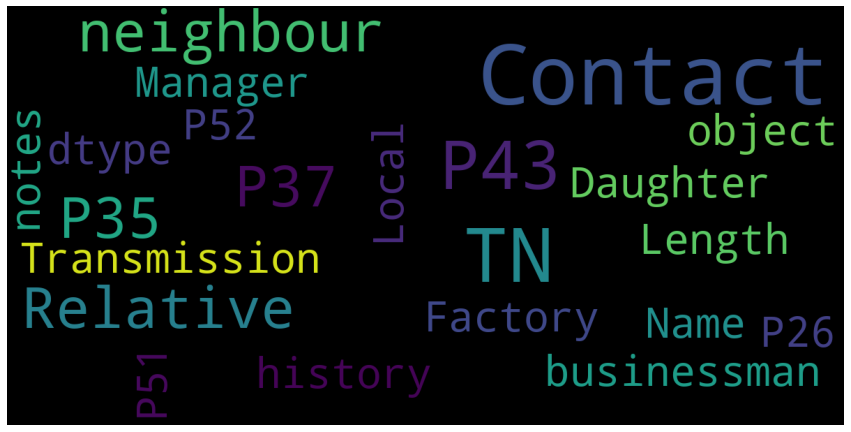

In [49]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(pep_no_trav_his['notes'].apply(lambda x: x.replace('travel', '')))
